In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd
from config import OPENAI_API_KEY, GOOGLE_API_KEY

In [39]:
BASE_DIR = 'data/CheXpert/'
SUBSET = 'val'

TEST_DIR = f'{BASE_DIR}{SUBSET}/'
TEST_PATH = f'{BASE_DIR}val_labels.csv'
DEMO_PATH = f'{BASE_DIR}CHEXPERT_DEMO.xlsx'
GROUND_PATH = f'{BASE_DIR}groundtruth.csv'
OUTPUT_FILE = f'{BASE_DIR}val_labels_processed.csv'

PATHOLOGIES = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
    'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
    'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
    'Fracture', 'Support Devices'
]

In [59]:
def load_data(test_path, demo_path, ground_truth_path):
    df = pd.read_csv(test_path)[['Path']]
    df['PATIENT'] = df['Path'].str.extract(r'(patient\d+)')
    df['Study'] = df['Path'].apply(lambda path: path.rsplit('/', 1)[0])

    # Read the Excel file
    demo_df = pd.read_excel(demo_path)
    df = df.merge(demo_df, on='PATIENT', how='left')
        
    if 'test'  in test_path:   
        # Get ground truth 
        ground_df = pd.read_csv(ground_truth_path)
        ground_df['Study'] = ground_df.Study.str.replace('CheXpert-v1.0/', '')
        df = df.merge(ground_df, on='Study', how='left')
        return df

    elif 'val' in test_path:
        labels_df = pd.read_csv(test_path)[['Path']+PATHOLOGIES]
        df = df.merge(labels_df, on='Path', how='left')
        df['Path'] = df['Path'].str.replace('CheXpert-v1.0/valid', 'val')

        return df

    else:
        return None

def assign_race(df, race):
    mask = df.PRIMARY_RACE.str.contains(race, na=False, case=False)
    df.loc[mask, "Race"] = race.capitalize()

def assign_ethnicity(row):
    ethnicity = str(row['ETHNICITY']).lower()
    primary_race = str(row['PRIMARY_RACE']).lower()

    if 'non-hispanic' in ethnicity or 'non-hispanic' in primary_race:
        return 'Non-Hispanic'
    elif 'hispanic' in ethnicity or 'hispanic' in primary_race:
        return 'Hispanic'
    else:
        return 'Unknown'

def process_data(test_path, demo_path, ground_truth):
    df = load_data(test_path, demo_path, ground_truth)

    for race in ["Black", "White", "Asian", "Other"]:
        assign_race(df, race)
    
    df['Race'] = df['Race'].fillna('Other')
    df['Ethnicity'] = df.apply(assign_ethnicity, axis=1)
    
    df = df[df['Path'].str.endswith('frontal.jpg')]
    df = df.drop_duplicates(subset='PATIENT', keep='first')
    
    return df

df = process_data(TEST_PATH, DEMO_PATH, GROUND_PATH)

In [62]:
df.to_csv(OUTPUT_FILE, index=False)

In [63]:
def analyze_pathologies(df, pathologies):
    # Count 'No Finding' and 'Not No Finding'
    no_finding_counts = df['No Finding'].value_counts()
    print(no_finding_counts)

    # Filter DataFrame to only include rows where 'No Finding' is 1
    no_finding_df = df[df['No Finding'] == 1]

    # Exclude 'No Finding' from pathologies
    other_pathologies = pathologies[1:]
    df['abnormal'] = (df[other_pathologies].sum(axis=1) > 0).astype(int)

    # Find rows where 'No Finding' is 1 and there's a 1 in another pathology column
    overlap_rows = no_finding_df[other_pathologies].sum(axis=1) > 0

    # Count such rows and print the count
    overlap_count = overlap_rows.sum()
    print(f"\nThere are {overlap_count} instances where 'No Finding' is 1 and there's a 1 in another pathology column.")

    # Print which columns there is a 1
    overlap_columns = no_finding_df.loc[overlap_rows, other_pathologies].any()
    print("\nThe following pathologies overlap with 'No Finding':", overlap_columns[overlap_columns].index.tolist())

analyze_pathologies(df, PATHOLOGIES)

No Finding
0.0    174
1.0     26
Name: count, dtype: int64

There are 0 instances where 'No Finding' is 1 and there's a 1 in another pathology column.

The following pathologies overlap with 'No Finding': []


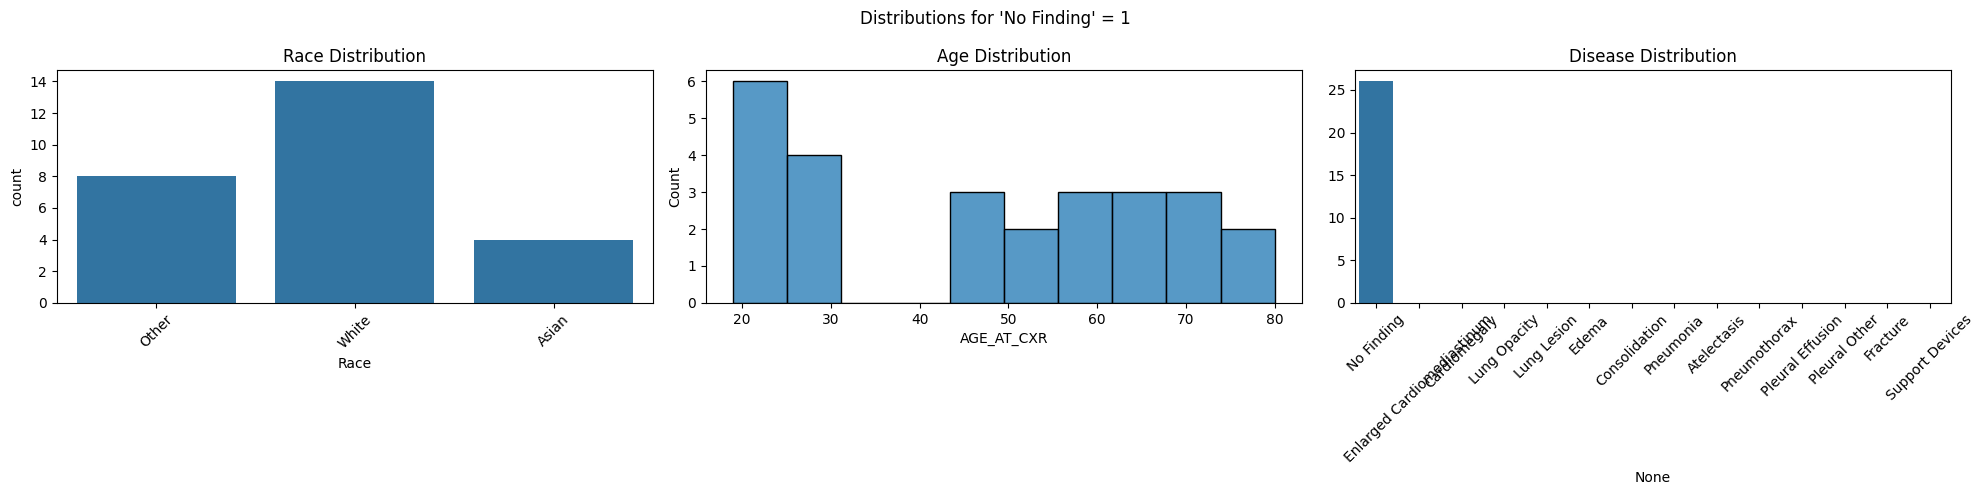

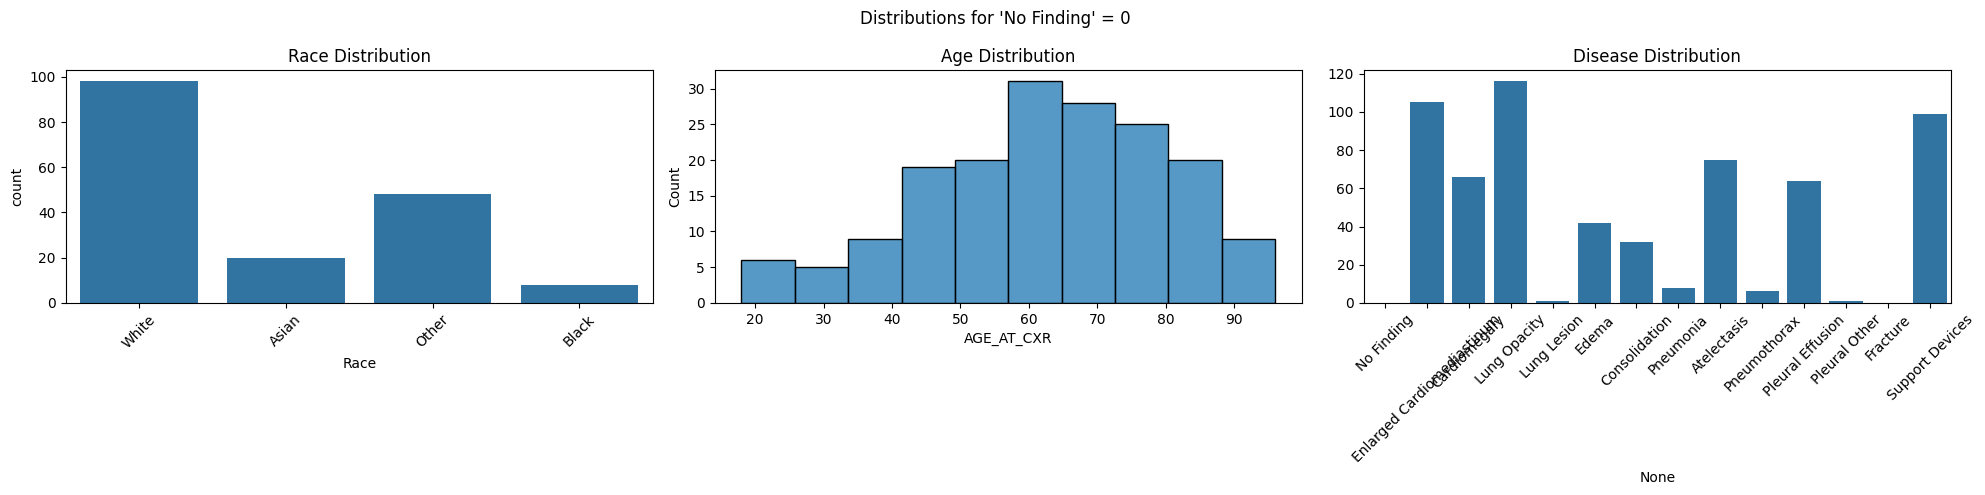

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot distributions
def plot_distributions(df, title):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(title)

    # Plot race distribution
    sns.countplot(ax=axes[0], x='Race', data=df)
    axes[0].set_title('Race Distribution')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot age distribution
    sns.histplot(ax=axes[1], x='AGE_AT_CXR', data=df, bins=10)
    axes[1].set_title('Age Distribution')

    # Plot disease distribution (if 'No Finding' is 0)
    if (df['No Finding'] < 2).any():
        disease_counts = df[PATHOLOGIES].sum()
        sns.barplot(ax=axes[2], x=disease_counts.index, y=disease_counts.values)
        axes[2].set_title('Disease Distribution')
        axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Plot distributions for rows where 'No Finding' is 1
no_finding_df = df[df['No Finding'] == 1]
plot_distributions(no_finding_df, "Distributions for 'No Finding' = 1")

# Plot distributions for rows where 'No Finding' is 0
no_finding_0_df = df[df['No Finding'] == 0]
plot_distributions(no_finding_0_df, "Distributions for 'No Finding' = 0")




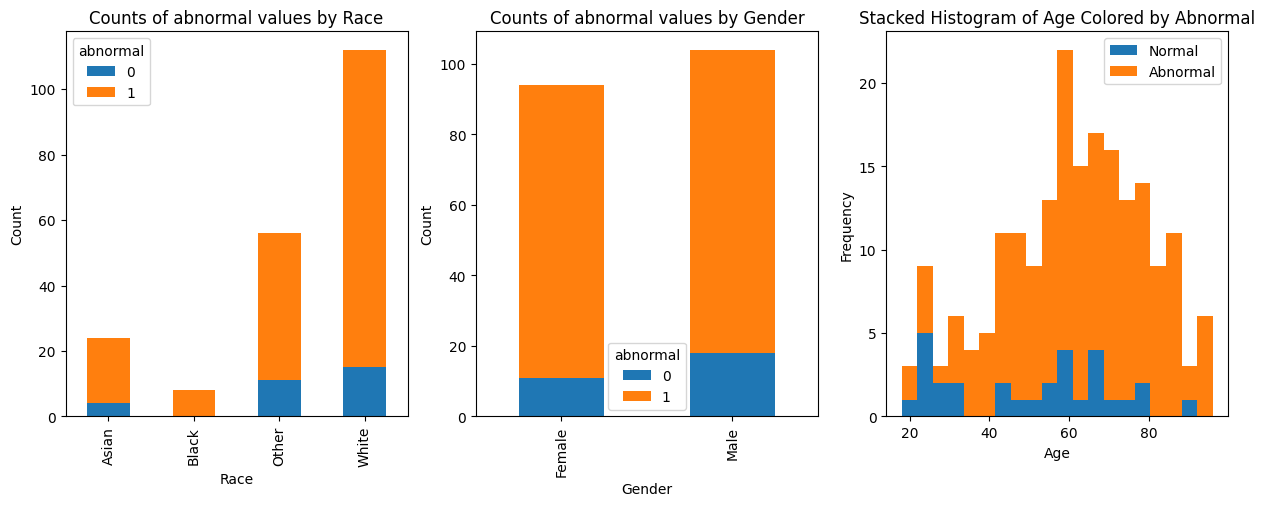

In [65]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plotting counts of abnormal values by Race
df.groupby('Race')['abnormal'].value_counts().unstack().plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Count')
axes[0].set_title('Counts of abnormal values by Race')

# Plotting counts of abnormal values by Gender
df.groupby('GENDER')['abnormal'].value_counts().unstack().plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
axes[1].set_title('Counts of abnormal values by Gender')

# Plotting counts of abnormal values by Age
df['AGE_AT_CXR'] = df['AGE_AT_CXR'].fillna(df['AGE_AT_CXR'].mean())


# Stacked histogram of age colored by abnormal
axes[2].hist([df[df['abnormal'] == 0]['AGE_AT_CXR'], df[df['abnormal'] == 1]['AGE_AT_CXR']], 
             bins=20, stacked=True, label=['Normal', 'Abnormal'])
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Stacked Histogram of Age Colored by Abnormal')
axes[2].legend()



In [66]:
test_df = pd.read_csv('data/processed_test_set_2024-03-10.csv')

# Reset the index of the dataframes
test_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
#df = df.loc[:,~df.columns.duplicated()]

# Add validation df to processed test set
master_df = pd.concat([test_df, df], ignore_index=True)
master_df.to_csv('data/processed_test_val_set_20240319.csv', index=False)